This is the version where I add the ESM Embedding in various formats so we can test them (using ESM + adding our own layers to tune the param more for our purposes): 
1. (simplest) concatenate the two sequences and encode with ESM only --> positional embedding together --> self attention
2. concatenate the two sequences and encode with ESM + 3 linear layers afterwards --> positional embedding together --> self attention
3. concatenate the two sequences and encode with ESM (all layers of ESM except the last three are frozen --> model will fine tune the last three layers for transfer learning) --> positional embedding together --> self attention
4. encode the two sequences with ESM only separately --> positional embedding separately --> cross attention
5. encode the two sequences with ESM + 3 linear layers afterwards separately --> positional embedding separately --> cross attention
6. encode the two sequences with ESM separately (all layers of ESM except the last three are frozen --> model will fine tune the last three layers for transfer learning) --> positional embedding separately --> cross attention


other sources of optionality: 
1. for each of the esm models, you can choose between taking the CLS token representation for classification (what wengong had suggested) or mean pooling 
    1. should we add a way to do it with just taking the raw values as well and projecting it to a dim of 1 before sigmoid (TODO)
2. activation function choice when you add 3 linear layers to the ESM embedding (need to add dropout and activation functions if you add three more layers since I have seen that done by convention but also I believe it helps with generalization and preventing the collapsing of the three linear layers into just one overall linear transformation (adding non-linearity to it using the activation functions) + preventing overfitting (adding the dropout in each of these linear layers)
    1. "To determine the best activation function for your model, consider experimenting with different options and evaluating their impact on your model's performance on a validation set. Activation functions can have different effects depending on the overall architecture and the specific characteristics of the data. For example, if you're finding that a significant number of neurons are dying (i.e., outputting zero across all inputs) with ReLU, you might try Leaky ReLU or PReLU. If you're experiencing issues with convergence or if your model benefits from smoother functions, GELU or Swish might offer improvements."

https://github.com/facebookresearch/esm/issues/348 and ChatGPT make me feel like the tokenizer and model are both needed for the embedding so I made a HuggingFace version since I think the facebook version we played with was complete but hard for me to see how to best add padding tokens to it (I think <pad> is enough, but wasn't sure so went this route to be safe!)

In [1]:
%reset -f
%whos

Interactive namespace is empty.


In [2]:
import os
import esm
from os.path import exists
#import fair_esm
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import log_softmax, pad
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
import copy
import time
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import re
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
from torch.utils.data import Dataset
import spacy
import GPUtil
import warnings
import seaborn
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from transformers import EsmTokenizer, EsmModel
from torch.utils.data import dataset
seaborn.set_context(context="talk")
%matplotlib inline

In [3]:
pd.options.display.max_rows = 4000

In [4]:
pan_len = pd.read_csv("/Users/jessikabaral/Downloads/MS_panlen_seed_757_5cv_x10p_train_test_valid.txt", sep = " ")
peptide_10mer = pd.read_csv("/Users/jessikabaral/Downloads/MS10_dat_dummy_seed_757_5cv_x10p_train_test_valid.txt", sep = " ")
peptide_10mer

,ABCG,length,allele,seed,fold,set,seq,label,boman,hmoment,hydrophobicity,helixbend,sidechain,xstr,partspec,pkc
0,A,10,A0101,123,2,valid,HTDDPLTWDY,1,2.885,0.075970,-0.001,0.455,0.171,-0.391,-0.073,0.113
1,A,10,A0101,123,2,valid,WVDDQRPENY,1,4.512,0.132024,0.329,0.360,0.373,-0.248,0.075,0.040
2,A,10,A0101,123,2,valid,LSDIGSGIRY,1,1.394,0.550009,0.000,0.422,-0.387,0.379,-0.314,-0.255
3,A,10,A0101,123,2,valid,ALTSRRRAQR,0,6.265,0.470852,0.799,-0.268,0.020,0.474,-0.140,0.023
4,A,10,A0101,123,2,valid,QASSLRLHQN,0,3.245,0.235895,0.353,-0.201,-0.163,-0.002,-0.272,0.157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695506,G,10,G0104,123,1,valid,KPRSSLGMHM,0,2.137,0.086025,0.122,0.077,-0.148,-0.128,-0.058,-0.407
2695507,G,10,G0104,123,1,valid,GVHQYIDADT,0,1.864,0.268986,0.147,0.035,-0.340,0.127,-0.024,0.076
2695508,G,10,G0104,123,1,valid,APGLLPYEPF,0,-0.862,0.059929,-0.570,0.372,-0.197,-0.630,-0.743,0.298
2695509,G,10,G0104,123,1,valid,VGRYLETKPA,0,1.828,0.351823,0.213,0.025,-0.161,0.099,-0.543,-0.193


In [5]:
peptide_10mer_subset = pd.concat([peptide_10mer[(peptide_10mer['fold'] == 0)].sample(frac=0.01), peptide_10mer[(peptide_10mer['fold'] == 1)].sample(frac=0.01)], ignore_index=True).copy()
peptide_10mer_subset = peptide_10mer_subset.sample(n=96)
peptide_10mer_subset


,ABCG,length,allele,seed,fold,set,seq,label,boman,hmoment,hydrophobicity,helixbend,sidechain,xstr,partspec,pkc
9057,B,10,B1503,123,1,train,AKCQQLQQEY,1,2.665,0.208262,0.429,-0.477,0.089,-0.152,0.004,0.079
7710,B,10,B1503,123,1,test,GDWMIEFYAP,0,0.034,0.232703,-0.426,0.043,0.059,-0.445,-0.016,-0.155
4597,B,10,B1301,123,0,train,RLEKNVKEVL,1,2.836,0.737044,0.542,-0.578,0.180,0.117,-0.733,-0.035
1893,A,10,A7401,123,0,train,RVADVYRYCR,1,4.259,0.497503,0.318,0.108,0.257,0.769,0.018,0.177
6450,B,10,B1510,123,1,train,FSALSSAYWS,0,-0.011,0.197359,-0.352,0.055,-0.310,-0.182,-0.625,-0.365
3062,B,10,B5801,123,0,train,HVAPVTSVEW,1,0.118,0.047392,-0.129,-0.221,-0.310,0.276,-0.190,-0.348
1133,A,10,A3601,123,0,train,VGRKVRRPAG,0,3.854,0.779978,0.517,0.226,-0.271,0.538,-0.331,-0.308
5993,B,10,B3801,123,1,train,HHVSPHETYF,1,1.988,0.186321,-0.008,0.088,0.139,0.025,0.046,0.345
7321,A,10,A0205,123,1,train,DREPGGVTQQ,0,3.818,0.350469,0.521,0.291,-0.394,-0.004,0.092,-0.302
8399,C,10,C0202,123,1,train,KLPEFTKSEY,1,2.293,0.317802,0.295,-0.032,0.237,-0.326,-0.665,-0.034


In [6]:
#TODO: CHANGE THE ORIGINAL ONE_HOT DOC TO HAVE BOS B IN IT
one_hot = pd.read_csv("/Users/jessikabaral/Documents/Documents - Jessika’s MacBook Pro/HLAthenav2/hlathenav2/hlathena/data/aafeatmat_onehot_ext.txt", sep = " ")
one_hot = one_hot.rename(index={'.': 'B'}, columns = {'.': 'B'})
one_hot_dict = {index: row.tolist() for index, row in one_hot.iterrows()}

kf = pd.read_csv("/Users/jessikabaral/Documents/Documents - Jessika’s MacBook Pro/HLAthenav2/hlathenav2/hlathena/data/aafeatmat_KideraFactors.txt", sep = " ")

pc = pd.read_csv("/Users/jessikabaral/Documents/Documents - Jessika’s MacBook Pro/HLAthenav2/hlathenav2/hlathena/data/aafeatmat_AAPropsPCA3.txt", sep = " ")
pc.loc["B"] = 0
pc_dict = {index: row.tolist() for index, row in pc.iterrows()}

hla_full_pc_kf_pseudoseq_wseq = pd.read_csv("/Users/jessikabaral/Documents/Documents - Jessika’s MacBook Pro/HLAthenav2/hlathenav2/JB_Analyses/added_data/ABCG_prot.parsed.clean.updated.ALL.FEATS.txt", sep = " ", index_col = 1)

hla_seq_df = hla_full_pc_kf_pseudoseq_wseq.seq.copy()
hla_seq_df_dict = {index: row.tolist() for index, row in pd.DataFrame(hla_seq_df).iterrows()}

amino_acid_mapping = { #B = BOS token
    'B': 0, 'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
    'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
    'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
    'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20, "-":21
}

In [7]:
def add_padding(sequence, max_len, padding_token = "-"):
    """
    Pads the amino acid sequence to a maximum length by adding the necessary number of padding tokens ("-") after the fourth amino acid

    Parameters: 
    - sequence (str): input amino acid sequence for peptide
    - max_len (int): maximum length you want to pad the sequence to 
    - padding_token (str): token used for padding
    
    Returns: 
    - str: padded amino acid sequence
    """
    difference = max_len - len(sequence)
    final_seq = sequence[:4] + padding_token*difference + sequence[4:]
    return(final_seq)
    
def get_param(df, tgt_col, pep_col, hla_col):
    y_data = df[tgt_col]
    x_data = df[pep_col]
    hla_name = df[hla_col]
    max_len = max_len = max([len(x) for x in x_data])
    return y_data, x_data, hla_name, max_len

def initialize_param(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

class PositionalEncoding(nn.Module): #from https://pytorch.org/tutorials/beginner/transformer_tutorial.html#:~:text=A%20sequence%20of%20tokens%20are,TransformerEncoderLayer.

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## Model Testing

In [40]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTV<pad><pad><pad>LAGG"),
    ("protein2", "MKTV<mask><mask><mask>LAGG"),
    ("protein25", "MKTV---LAGG"),
    ("protein3",  "K A <pad> I S Q"),
    ("protein4",  "KA<pad>ISQ"),
    ("protein5",  "KA<mask>ISQ"),
    ("protein6",  "KAISQ"),
    ("protein7",  "AAAAAA"),
    ("protein8",  "AAA<pad>AAA"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]
token_representations

tensor([[[ 0.0428,  0.0144, -0.0614,  ..., -0.2851,  0.2332, -0.0849],
         [ 0.0453, -0.0352,  0.1409,  ...,  0.2414, -0.0953, -0.0510],
         [-0.0402, -0.0428,  0.0304,  ...,  0.0225,  0.0020,  0.0883],
         ...,
         [-0.0226,  0.0079,  0.1673,  ...,  0.2378, -0.2358,  0.1164],
         [-0.0172, -0.0139,  0.1728,  ...,  0.0375, -0.1610, -0.0760],
         [-0.0083, -0.0844,  0.1160,  ..., -0.1640,  0.1335, -0.0908]],

        [[ 0.0356,  0.0215, -0.0530,  ..., -0.2710,  0.2303, -0.1039],
         [-0.0154, -0.0590,  0.1156,  ...,  0.2249, -0.1520, -0.0754],
         [-0.0766, -0.0478,  0.0293,  ..., -0.0090, -0.0257,  0.1041],
         ...,
         [-0.0229,  0.0511,  0.1174,  ...,  0.2288, -0.2029,  0.0457],
         [ 0.0053, -0.0584,  0.1315,  ...,  0.0879, -0.1537, -0.0967],
         [-0.0095, -0.0565,  0.0971,  ..., -0.1617,  0.1483, -0.0926]],

        [[ 0.0352,  0.0223, -0.0546,  ..., -0.2720,  0.2313, -0.1033],
         [-0.0167, -0.0667,  0.1203,  ...,  0

In [41]:
token_representations.shape

torch.Size([9, 13, 1280])

In [ ]:
data = [
    ("protein1", "MKTV<pad><pad><pad>LAGG"),
    ("protein2", "MKTV<mask><mask><mask>LAGG"),
    ("protein25", "MKTV---LAGG"),
    ("protein3",  "K A <pad> I S Q"),
    ("protein4",  "KA<pad>ISQ"),
    ("protein5",  "KA<mask>ISQ"),
    ("protein6",  "KAISQ"),
    ("protein7",  "AAAAAA"),
    ("protein8",  "AAA<pad>AAA"),
]

In [51]:
batch_tokens

tensor([[ 0, 20, 15, 11,  7,  1,  1,  1,  4,  5,  6,  6,  2],
        [ 0, 20, 15, 11,  7, 32, 32, 32,  4,  5,  6,  6,  2],
        [ 0, 20, 15, 11,  7, 30, 30, 30,  4,  5,  6,  6,  2],
        [ 0, 15,  5,  1, 12,  8, 16,  2,  1,  1,  1,  1,  1],
        [ 0, 15,  5,  1, 12,  8, 16,  2,  1,  1,  1,  1,  1],
        [ 0, 15,  5, 32, 12,  8, 16,  2,  1,  1,  1,  1,  1],
        [ 0, 15,  5, 12,  8, 16,  2,  1,  1,  1,  1,  1,  1],
        [ 0,  5,  5,  5,  5,  5,  5,  2,  1,  1,  1,  1,  1],
        [ 0,  5,  5,  5,  1,  5,  5,  5,  2,  1,  1,  1,  1]])

In [48]:
alphabet.padding_idx

1

In [42]:
batch_lens

tensor([10, 13, 13,  7,  7,  8,  7,  8,  8])

In [46]:
sequence_representations

[tensor([ 0.0356,  0.0058,  0.0975,  ...,  0.1556, -0.1289,  0.0456]),
 tensor([-0.0023,  0.0042,  0.0851,  ...,  0.1401, -0.1361,  0.0390]),
 tensor([-0.0032,  0.0068,  0.0855,  ...,  0.1416, -0.1361,  0.0406]),
 tensor([ 0.0096,  0.1604,  0.0180,  ...,  0.0481, -0.1081,  0.0056]),
 tensor([ 0.0096,  0.1604,  0.0180,  ...,  0.0481, -0.1081,  0.0056]),
 tensor([ 0.0084,  0.1425,  0.0506,  ...,  0.0403, -0.1063,  0.0079]),
 tensor([-0.0032,  0.1404,  0.0281,  ...,  0.0425, -0.1192,  0.0148]),
 tensor([-0.1254,  0.1185, -0.0388,  ...,  0.0804, -0.0446,  0.0974]),
 tensor([-0.0812,  0.0932, -0.0362,  ...,  0.0863, -0.0539,  0.1304])]

In [47]:
sequence_representations[0].shape

torch.Size([1280])

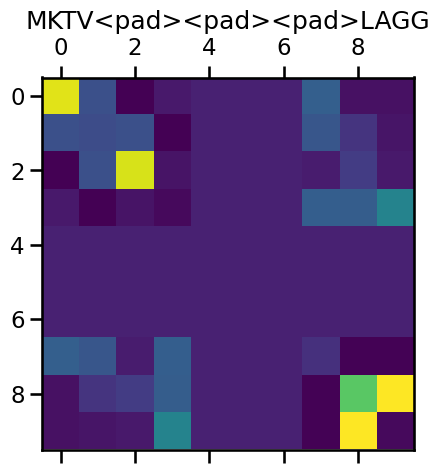

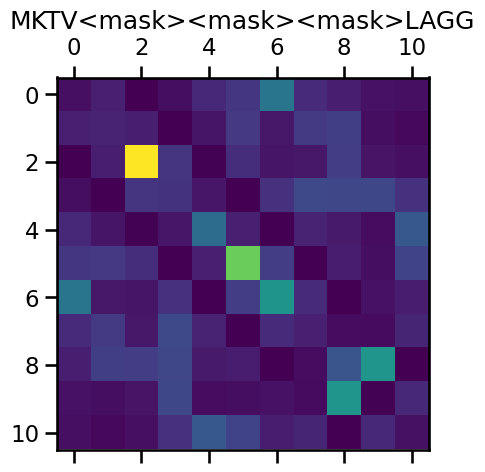

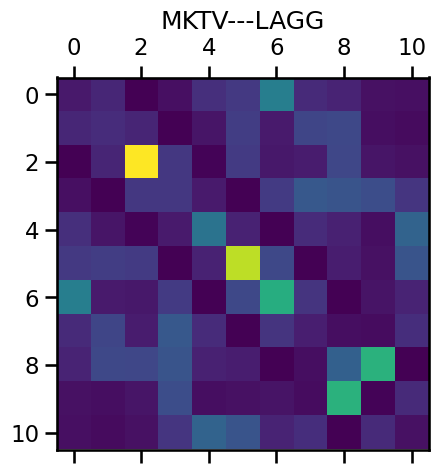

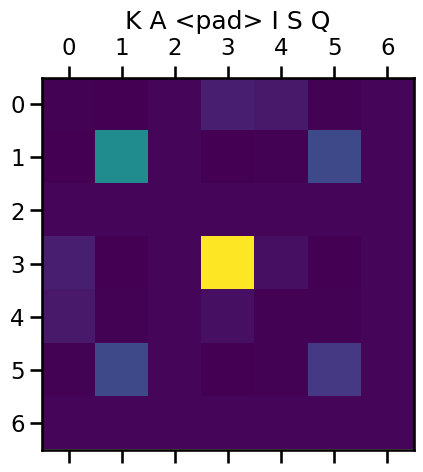

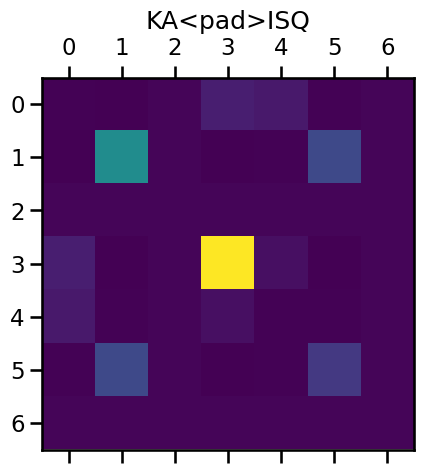

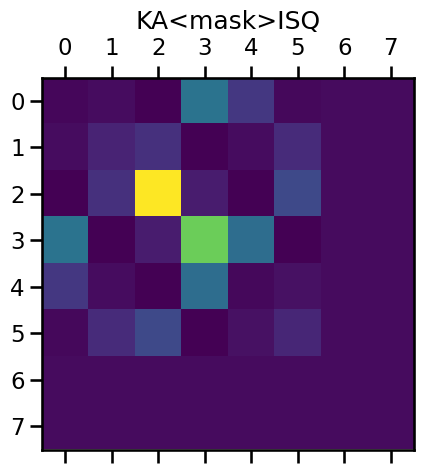

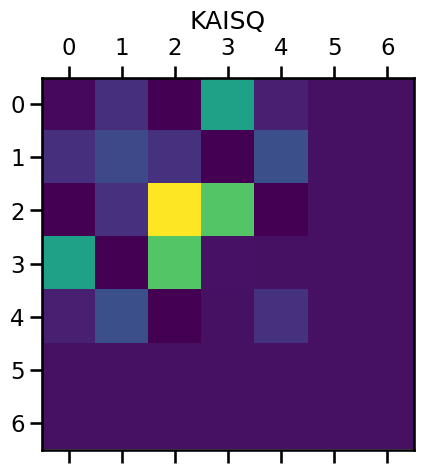

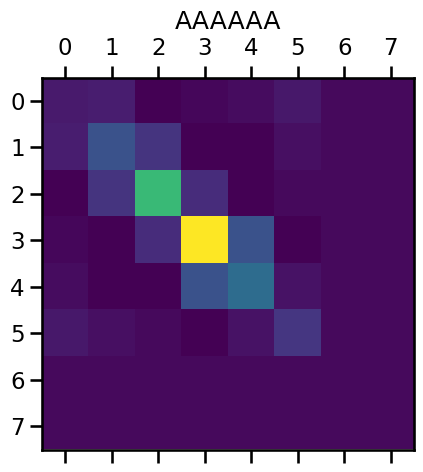

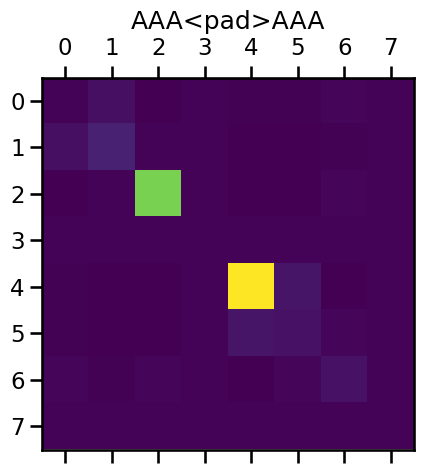

In [45]:
# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()

In [61]:
def transform_peptide_hla_sep(hla_seq, peptide_seq, max_len, encode_choice="embed"):
    padded_seq = add_padding(peptide_seq, max_len, "-")
    
    #converted this code to be for just one peptide since that is what the dataloader needs
    if encode_choice == "embed":
        peptide_processed = torch.tensor([amino_acid_mapping[aa] for aa in padded_seq])
        hla_processed = torch.tensor([amino_acid_mapping[aa] for aa in hla_seq])
        padding_mask = (peptide_processed != amino_acid_mapping["-"]).unsqueeze(1)
        
    elif encode_choice == "esm":
        padded_seq = add_padding(peptide_seq, max_len, "<pad>")
        peptide_input = [("Peptide_Input", padded_seq)]
        hla_input = [("HLA_Input", hla_seq)]
        
        peptide_batch_labels, peptide_batch_strs, peptide_batch_tokens = esm_batch_converter(peptide_input)
        hla_batch_labels, hla_batch_strs, hla_batch_tokens = esm_batch_converter(hla_input)

        # Extract per-residue representations (on CPU)
        with torch.no_grad():
            peptide_results = esm_model(peptide_batch_tokens, repr_layers=[33], return_contacts=True)
            hla_results = esm_model(hla_batch_tokens, repr_layers=[33], return_contacts=True)
        
        peptide_processed = peptide_results["representations"][33]
        hla_processed = hla_results["representations"][33]
        
        #this is the padding mask for the transformer (padding for the esm model has already been incorporated into the <pad> token for esm_model to deal with - double check! TODO)
        padding_mask = (peptide_batch_tokens == esm_alphabet.padding_idx).unsqueeze(1) #QUESTION/TODO: Do I need to unsqueeze this? this is currently [batch_size, seq_length]
        
    elif encode_choice == "one_hot":
        peptide_processed = torch.tensor([one_hot_dict[aa] for aa in padded_seq])
        hla_processed = torch.tensor([one_hot_dict[aa] for aa in hla_seq])
        padding_bool = [aa != "-" for aa in padded_seq]
        padding_mask = torch.tensor(padding_bool).unsqueeze(1)

    elif encode_choice == "pc":
        peptide_processed = torch.tensor([pc_dict[aa] for aa in padded_seq])
        hla_processed = torch.tensor([pc_dict[aa] for aa in hla_seq])
        padding_bool = [aa != "-" for aa in padded_seq]
        padding_mask = torch.tensor(padding_bool).unsqueeze(1)
    else:
        raise ValueError(f"Unsupported encoding choice: {encode_choice}. Must be 'one_hot', 'esm', embed', or 'pc'")
    
    return hla_processed, peptide_processed, padding_mask

#-----------------------------------------------------------
#before using esm, need to define esm_model and esm_batch_converter: 
#esm_model, esm_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
#esm_batch_converter = esm_alphabet.get_batch_converter()
#TODO: according to https://github.com/facebookresearch/esm/blob/main/esm/constants.py#L7, "-" is recognized by the model as <unk>, not <pad> so I might make that more explicit somehow --> TODO
#NOTE: according to https://github.com/search?q=repo%3Afacebookresearch%2Fesm%20%3Cpad%3E&type=code, "<pad>" is used to get the padding_idx (and in the above, you see that it corresponds to 1 and the padded parts also correspond to 1 at the end of the seq)
#NOTE: changed this such that aa == "-" is used for padding mask instead of aa != "-" since usually True means ignore the position and False means don't ignroe the position
def transform_peptide_hla_concat(hla_seq, peptide_seq, max_len, encode_choice="embed", esm_model = None, esm_batch_converter = None, esm_alphabet = None):
    padded_seq = add_padding(peptide_seq, max_len, "-")
    concat_seq = padded_seq + hla_seq
    
    #TODO: for all of these, check that it should be unsqueeze(1)
    #converted this code to be for just one peptide since that is what the dataloader needs
    if encode_choice == "embed":
        concat_processed = torch.tensor([amino_acid_mapping[aa] for aa in concat_seq])
        padding_mask = (concat_processed == amino_acid_mapping["-"]).unsqueeze(1)
        
    #TODO: check if this is correctly implemented for a one peptide at a time basis 
    elif encode_choice == "esm":
        padded_seq = add_padding(peptide_seq, max_len, "<pad>")
        concat_seq = padded_seq + hla_seq
        concat_input = [("Concat_Input", concat_seq)]
        concat_batch_labels, concat_batch_strs, concat_batch_tokens = esm_batch_converter(concat_input)
        #concat_batch_lens = (concat_batch_tokens != esm_alphabet.padding_idx).sum(1) #only need this if you want to later use the means instead of the token representations for each amino acid
        
        # Extract per-residue representations (on CPU)
        with torch.no_grad():
            concat_results = esm_model(concat_batch_tokens, repr_layers=[33], return_contacts=True)
        concat_processed = concat_results["representations"][33]
        #this is the padding mask for the transformer (padding for the esm model has already been incorporated into the <pad> token for esm_model to deal with - double check! TODO)
        padding_mask = (concat_batch_tokens == esm_alphabet.padding_idx).unsqueeze(1) #QUESTION/TODO: Do I need to unsqueeze this? this is currently [batch_size, seq_length]
        
    elif encode_choice == "one_hot":
        concat_processed = torch.tensor([one_hot_dict[aa] for aa in concat_seq])
        padding_bool = [aa == "-" for aa in concat_seq]
        padding_mask = torch.tensor(padding_bool).unsqueeze(1)

    elif encode_choice == "pc":
        concat_processed = torch.tensor([pc_dict[aa] for aa in concat_seq])
        padding_bool = [aa == "-" for aa in concat_seq]
        padding_mask = torch.tensor(padding_bool).unsqueeze(1)
    else:
        raise ValueError(f"Unsupported encoding choice: {encode_choice}. Must be 'one_hot', 'esm', embed', or 'pc'")
    
    return concat_processed, padding_mask


In [83]:
#use this if you want to create the train dataset automatically and can input the whole original file (no need to separate out the train and validation from each other beforehand)
class PeptideHLADataset_Training_Validation(Dataset):
    def __init__(self, input_df, hla_seq_df, tgt_col, pep_col, hla_col, fold_num_val, train_or_val, max_len, encode_choice = "embed", transform=None):
        self.input_df = input_df
        self.hla_seq_df = hla_seq_df
        self.tgt_col = tgt_col
        self.pep_col = pep_col
        self.hla_col = hla_col
        self.max_len = max_len
        self.fold_num_val = fold_num_val
        self.train_or_val = train_or_val
        self.encode_choice = encode_choice
        self.transform = transform
        self.train_df = input_df[input_df['fold'] != fold_num_val]
        self.val_df = input_df[input_df['fold'] == fold_num_val]

    def __len__(self):
        if self.train_or_val == "train":
            return len(self.train_df)
        elif self.train_or_val == "validation":
            return len(self.val_df)

    def __getitem__(self, idx):
        #print(idx)
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if self.train_or_val == "train":
            sample = self.train_df.iloc[idx]
        elif self.train_or_val == "validation":
            sample = self.val_df.iloc[idx]
            
        peptide = sample[self.pep_col]
        hla_name = sample[self.hla_col]
        label = sample[self.tgt_col]
        #label = torch.tensor(sample[self.tgt_col]).unsqueeze(1) #TODO: i added the unsqueeze here -- is that right?
                
        #hla_name_processed = re.sub(r'[\*:]', '', hla_name.split("-")[1]) #not needed since the input data has hla in the correct format now
        #hla_sequence = self.hla_seq_df[hla_name_processed].values[0]    
        hla_sequence = self.hla_seq_df[hla_name]

        if self.transform:
            #why doesn't this work if you add the self.max_len into it?
            hla_sequence, peptide, padding_mask = self.transform(hla_sequence, peptide, self.max_len, self.encode_choice)
        else: 
            raise RuntimeError("Transform function is not defined. Please define it.")
            
        return hla_sequence, peptide, padding_mask, label
    
def get_data_loaders(input_df, hla_seq_df, tgt_col, pep_col, hla_col, fold_num_val, max_len, batch_size = 32, encode_choice = 'embed', concat_sep = "concat"):
    if concat_sep == "concat":
        transform_function = lambda h_seq, p_seq, max_len, encode_choice: transform_peptide_hla_concat(h_seq, p_seq, max_len, encode_choice)
    elif concat_sep == "sep":
        transform_function = lambda h_seq, p_seq, max_len, encode_choice: transform_peptide_hla_sep(h_seq, p_seq, max_len, encode_choice)
    else:
        raise ValueError("concat_sep argument must be either 'concat' or 'sep'")
        
    train_dataset = PeptideHLADataset_Training_Validation(input_df, hla_seq_df, tgt_col, pep_col, hla_col, fold_num_val, "train", max_len = max_len, transform = transform_function, encode_choice = encode_choice)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = PeptideHLADataset_Training_Validation(input_df, hla_seq_df, tgt_col, pep_col, hla_col, fold_num_val, "validation", max_len = max_len, transform = transform_function, encode_choice = encode_choice)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader


In [85]:
#make sure to have model.train() right before using this function
def train_model(model, train_loader, model_type, optimizer, criterion, epoch, concat_sep):
    model.train()
    running_loss = 0.0
    if concat_sep == "concat":
        for batch_idx, (concat_processed, padding_mask, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(concat_processed.long(), padding_mask, model_type).squeeze() #(reduce a dim so it matches the dim of the labels [32] instead of [32, 1])
            loss = criterion(outputs, labels.float())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if batch_idx % 10 == 9:  #Print average loss every 10 mini-batches
                print(f'Training Epoch: {epoch + 1}, Batch: {batch_idx + 1}, Loss: {running_loss / 10:.4f}')
                running_loss = 0.0
    elif concat_sep == "sep":
        for batch_idx, (hla_processed, peptide_processed, padding_mask, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(hla_processed.long(), peptide_processed.long(), padding_mask, model_type).squeeze() #(reduce a dim so it matches the dim of the labels [32] instead of [32, 1])
            loss = criterion(outputs, labels.float())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if batch_idx % 10 == 9:  #Print average loss every 10 mini-batches
                print(f'Training Epoch: {epoch + 1}, Batch: {batch_idx + 1}, Loss: {running_loss / 10:.4f}')
                running_loss = 0.0
    else:
        raise ValueError("concat_sep argument must be either 'concat' or 'sep'")
    
def eval_model(model, val_loader, model_type, threshold, criterion, concat_sep):
    model.eval()
    total_correct, total_samples = 0, 0
    
    if concat_sep == "concat":
        with torch.no_grad():
            for batch_idx, (concat_processed, padding_mask, labels) in enumerate(val_loader):
                #IMPT: only have the squeeze here if you are doing binary classification w sigmoid classification! if you use softmax for 2 classes, take this out
                output = model(concat_processed.long(), padding_mask, model_type).squeeze()
                #predicted = torch.argmax(output, dim=1) #for softmax
                predicted = (output >= threshold).long() #for sigmoid
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)
    elif concat_sep == "sep":
        with torch.no_grad():
            for batch_idx, (hla_processed, peptide_processed, padding_mask, labels) in enumerate(val_loader):
                #IMPT: only have the squeeze here if you are doing binary classification w sigmoid classification! if you use softmax for 2 classes, take this out
                output = model(hla_processed.long(), peptide_processed.long(), padding_mask, model_type).squeeze()
                #predicted = torch.argmax(output, dim=1) #for softmax
                predicted = (output >= threshold).long() #for sigmoid
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)
    else:
        raise ValueError("concat_sep argument must be either 'concat' or 'sep'")
            
    accuracy = total_correct / total_samples
    return accuracy

def train_and_eval(model, train_loader, val_loader, model_type, threshold, criterion, optimizer, epochs=10, concat_sep = "concat"):
    if optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
    for epoch in range(epochs):
        # training
        train_model(model, train_loader, model_type, optimizer, criterion, epoch, concat_sep)
        # eval
        accuracy = eval_model(model, val_loader, model_type, threshold, criterion, concat_sep)
        print(f'Eval Epoch: {epoch + 1}, Validation Accuracy: {accuracy:.4f}')
    print('Finished Training and Evaluation')


In [63]:
#TODO: can delete the peptide only and hla only parts later if we confirm we don't need them! (just keep concat parts)
concat_input = []
peptide_esm_input = []
hla_esm_input = []

for index, row in peptide_10mer_subset.iterrows():
    concat_input.append(("Concat_Input " + str(index), row.seq + hla_seq_df_dict[row.allele][0]))
    peptide_esm_input.append(("Peptide " + str(index), row.seq))
    hla_esm_input.append(("HLA " + str(index), hla_seq_df_dict[row.allele][0]))

concat_input

[('Concat_Input 10138',
  'TYIIPRSVLFGSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITKRKWEAAHVAEQQRAYLEGTCVDGLRRYLENGKETLQRT'),
 ('Concat_Input 5584',
  'RYYKNIGLGFGSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVDGLRRYLENGKETLQRT'),
 ('Concat_Input 9558',
  'FTVKWLRRSRGSHSMRYFYTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRTALRYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVESLRRYLENGKETLQRA'),
 ('Concat_Input 331',
  'KQLEIAHEKLGSHSMRYFYTAMSRPGRGEPRFITVGYVDDTQFVRFDSDATSPRMAPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRTALRYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHNQLAYDGKDYIALNEDLSSWTAADTAAQITQLKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQRA'),
 ('Concat_Input 5958',
  'RTLSDYNIQKGSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAQSQTDRV

In [64]:
hla_esm_input

[('HLA 10138',
  'GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITKRKWEAAHVAEQQRAYLEGTCVDGLRRYLENGKETLQRT'),
 ('HLA 5584',
  'GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVDGLRRYLENGKETLQRT'),
 ('HLA 9558',
  'GSHSMRYFYTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRTALRYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVESLRRYLENGKETLQRA'),
 ('HLA 331',
  'GSHSMRYFYTAMSRPGRGEPRFITVGYVDDTQFVRFDSDATSPRMAPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRTALRYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHNQLAYDGKDYIALNEDLSSWTAADTAAQITQLKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQRA'),
 ('HLA 5958',
  'GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTIQIMYGCDVGSDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAAHEAEQLRAYLDGTCVEWLRRY

In [65]:
peptide_esm_input

[('Peptide 10138', 'TYIIPRSVLF'),
 ('Peptide 5584', 'RYYKNIGLGF'),
 ('Peptide 9558', 'FTVKWLRRSR'),
 ('Peptide 331', 'KQLEIAHEKL'),
 ('Peptide 5958', 'RTLSDYNIQK'),
 ('Peptide 2312', 'PAALYGFPST'),
 ('Peptide 8760', 'DTAARLSYQN'),
 ('Peptide 5976', 'LHNFEEMVKV'),
 ('Peptide 1472', 'TLIEDEIATI'),
 ('Peptide 8184', 'WHIYSEEEYL')]

## Model 1

In [66]:
#get esm embeddings for your data
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
#model.eval()  # disables dropout for deterministic results

concat_data = concat_input
concat_batch_labels, concat_batch_strs, concat_batch_tokens = batch_converter(concat_data)
concat_batch_lens = (concat_batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    concat_results = model(concat_batch_tokens, repr_layers=[33], return_contacts=True)
concat_token_representations = concat_results["representations"][33]

concat_token_representations.shape

torch.Size([10, 194, 1280])

In [67]:
len("KNQRALKLGTGSHSMRYFYTAMSRPVRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRESLRNLRGYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQRA")

192

In [68]:
len(model.layers)

33

**Note on why you need the additional linear layer at the end of the transformer and before the sigmoid** (I was confused about this at first!): after you go through the transformer encoder, the output is in the shape of [seq_len, batch_size, input_dim] --> when you apply pooling strategy (mean or cls versions), you reduce seq length dim so now you have a dim of [batch_size, input_dim] --> classifier layer then serves to map this high-dim vector of dim = input_dum to a single value that represents probability that input seq is a binder or non-binder (aka classifier layer project the high dim encoded representation per peptide seq in batch down to a single scalar value for each peptide seq in the batch so it can go through binary classification) --> then you put that final value through the sigmoid activation function. 

**src_mask vs src_key_padding_mask**:
1. src_mask: prevents model from paying attention to certain positions in the input seq (useful if you want causal/autoregressive masking where you want the model to only be able to look at amino acids up to a ceratin position (i.e. if you are predicting which amino acid came next based on previous amino acids or something). you can also use this mask to exclude certain tokens that should not be paid attention to (special tokens or something)
    1. dim = [seq_len, seq_len] (matches dim of the attention scores)
2. src_key_padding_mask: don't pay attention to padding tokens for self-attention calculations (what we will use here)
    2. dim = [batch_size, seq_len]; each element in the mask is a boolean indicating whether the corresponding token is a padding token (True) or not (False)
    
3. aka src_mask is used for specifying which tokens should not be attended to by any other token, while src_key_padding_mask is specifically for indicating padding tokens that should be ignored by the attention mechanism
    1. "Dimensions: src_mask has dimensions [seq_len, seq_len], allowing it to specify attention restrictions at the token level for the entire sequence. src_key_padding_mask has dimensions [batch_size, seq_len], indicating padding tokens across different sequences in a batch"

In [75]:
#works
'''class TransformerEncoderClassifier_Model1(nn.Module):
    def __init__(self, input_dim, num_layers, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoderClassifier_Model1, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(input_dim, 1) #bring it back to dim 1 for sigmoid classifier (if using softmax, change this to 2)

    def forward(self, src, pooling_strat = "mean", src_mask=None, src_key_padding_mask=None):
        #change src (input) shape from [batch_size, seq_len, input_dim] to [seq_len, batch_size, input_dim] (latter is more common for pytorch built-in implementations)
        src = src.permute(1, 0, 2)
        
        #run model
        encoded_interim = self.transformer_encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        
        ## Three ways to do this: take the representation of the [CLS] token, take the mean pooling strategy, 
        # or take the raw values themselves (unsure if the last one is actually used in practice!!)
        if pooling_strat == "mean":
            encoded = encoded_interim.mean(dim=0)
        elif pooling_strat == "CLS":
            #assuming CLS is the first token at position 0 (assuming it is the same as SOS token for our purposes - check with Wengong [TODO])
            encoded = encoded_interim[0]
        #run classifier (bring it down to one neuron then use sigmoid classifier)
        logits = self.classifier(encoded)
        return torch.sigmoid(logits)'''

In [ ]:
#works 
'''class TransformerEncoderClassifier_Model1(nn.Module):
    def __init__(self, input_dim, num_layers, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoderClassifier_Model1, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(input_dim, 1) #bring it back to dim 1 for sigmoid classifier (if using softmax, change this to 2)

    def forward(self, src, pooling_strat = "mean", model_type = "esm", src_mask=None, src_key_padding_mask=None):
        #change src (input) shape from [batch_size, seq_len, input_dim] to [seq_len, batch_size, input_dim] (latter is more common for pytorch built-in implementations)
        #src = src.permute(1, 0, 2) -- added batch_first=True so do not need this anymore
        
        #run model
        encoded_interim = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)
        
        ## Three ways to do this: take the representation of the [CLS] token, take the mean pooling strategy, 
        # or take the raw values themselves (unsure if the last one is actually used in practice!!)
        if pooling_strat == "mean":
            encoded = encoded_interim.mean(dim=1) #changed dim = 0 to dim = 1 since that is now the seq_len dim
        elif pooling_strat == "CLS":
            #assuming CLS is the first token at position 0 (assuming it is the same as SOS token for our purposes - check with Wengong [TODO])
            # With batch_first=True, the CLS token for each sequence is at position 0 along the seq_len dimension, but since we're iterating over batch, index over each item in the batch.
            encoded = encoded_interim[:, 0, :]
        #run classifier (bring it down to one neuron then use sigmoid classifier)
        logits = self.classifier(encoded)
        return torch.sigmoid(logits)'''

In [98]:
class TransformerEncoderClassifier_Model1(nn.Module):
    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int, nlayers: int, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(ntoken, d_model) #not used in esm model!
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.linear = nn.Linear(d_model, 1) #bring it back to dim 1 for sigmoid classifier (if using softmax, change this to 2)

    def forward(self, src, pooling_strat = "mean", model_type = "esm", src_mask=None, src_key_padding_mask=None) -> Tensor:
        #change src (input) shape from [batch_size, seq_len, input_dim] to [seq_len, batch_size, input_dim] (latter is more common for pytorch built-in implementations)
        #src = src.permute(1, 0, 2) -- added batch_first=True so do not need this anymore
        
        if model_type == "esm": 
            #src = self.embedding(src) #add this back in when you generalize the model for other types
            src = self.pos_encoder(src)
        else:
            src = self.embedding(src) #add this back in when you generalize the model for other types
            src = self.pos_encoder(src)
        
        #run model
        encoded_interim = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)
        
        ## Three ways to do this: take the representation of the [CLS] token, take the mean pooling strategy, 
        # or take the raw values themselves (unsure if the last one is actually used in practice!!)
        if pooling_strat == "mean":
            encoded = encoded_interim.mean(dim=1) #changed dim = 0 to dim = 1 since that is now the seq_len dim
        elif pooling_strat == "CLS":
            #assuming CLS is the first token at position 0 (assuming it is the same as SOS token for our purposes - check with Wengong [TODO])
            # With batch_first=True, the CLS token for each sequence is at position 0 along the seq_len dimension, but since we're iterating over batch, index over each item in the batch.
            encoded = encoded_interim[:, 0, :]
        #run classifier (bring it down to one neuron then use sigmoid classifier)
        logits = self.linear(encoded)
        return torch.sigmoid(logits)

In [102]:
###TEST IT ON A MINI SET
input_dim = concat_token_representations.shape[2]
num_layers = 6 #can change
num_heads = 8 #can change
d_ff = 2048
#CHANGE THIS TO MATCH WHAT YOU NEED WHEN YOU ADD PADDING
padding_mask = torch.zeros(10, 194, dtype=torch.bool)


model = TransformerEncoderClassifier_Model1(ntoken = 22, 
                                            d_model = input_dim, 
                                            nhead = num_heads, 
                                            d_hid = d_ff, 
                                            nlayers = num_layers, 
                                            dropout = 0.1)
initialize_param(model)
labels = torch.tensor(peptide_10mer_subset.label.values).unsqueeze(1).float()
output = model(concat_token_representations, model_type = "esm", src_key_padding_mask = padding_mask)

criterion = nn.BCELoss()
loss = criterion(output, labels)

print("Output:", output)
print("Loss:", loss.item())

Output: tensor([[0.7686],
        [0.7043],
        [0.7189],
        [0.6996],
        [0.7461],
        [0.7802],
        [0.8281],
        [0.7967],
        [0.7769],
        [0.7186]], grad_fn=<SigmoidBackward0>)
Loss: 0.7985034584999084


In [ ]:
x, y = transform_peptide_hla_concat(hla_seq, peptide_seq, max_len, encode_choice="embed", esm_model = None, esm_batch_converter = None, esm_alphabet = None)


In [103]:
max_len = max([len(x) for x in peptide_10mer_subset.seq])
input_dim = concat_token_representations.shape[2] #1280
num_layers = 6 #can change
num_heads = 8 #can change
d_ff = 2048
criterion = nn.BCELoss()

fold_values = [0, 1] #!!!! CHANGE/TODO: alter if needed (this is just for the subset; the whole thing has 0 - 4)

for val_fold_num in fold_values:
    model = TransformerEncoderClassifier_Model1(ntoken = 22, 
                                            d_model = input_dim, 
                                            nhead = num_heads, 
                                            d_hid = d_ff, 
                                            nlayers = num_layers, 
                                            dropout = 0.1)
    initialize_param(model)
    train_loader, val_loader = get_data_loaders(peptide_10mer_subset, hla_seq_df, "label", "seq", "allele", val_fold_num, max_len, batch_size = 32, encode_choice = encode_choice, concat_sep = "concat")
    train_and_eval(
        model=model, 
        train_loader=train_loader, 
        val_loader=val_loader, 
        model_type="esm", 
        threshold=0.5, 
        criterion=criterion, 
        optimizer="Adam", 
        epochs=10, 
        concat_sep="concat"
    )

TypeError: 'NoneType' object is not callable

In [107]:
max_len = max([len(x) for x in peptide_10mer_subset.seq])
encode_choice = "esm"
criterion = nn.BCELoss()
train_loader, val_loader = get_data_loaders(peptide_10mer_subset, hla_seq_df, "label", "seq", "allele", 1, max_len, batch_size = 32, encode_choice = encode_choice)


In [113]:
train_dataset = PeptideHLADataset_Training_Validation(peptide_10mer_subset, hla_seq_df, "label", "seq", "allele", 0, "train", max_len = max_len, transform = transform_peptide_hla_concat, encode_choice = "esm")
train_dataset

## Model 2

In [118]:
class TransformerEncoderClassifier_Model2(nn.Module):
    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int, nlayers: int, dropout: float = 0.1, fine_tune_dim1: int = 512, fine_tune_dim2: int = 512):
        super().__init__()
        
        self.d_model = d_model
        self.embedding = nn.Embedding(ntoken, d_model) #not used in esm model!
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # Adding 3 linear layers for fine-tuning ESM embeddings
        self.linear1 = nn.Linear(input_dim, fine_tune_dim1)
        self.linear2 = nn.Linear(fine_tune_dim1, fine_tune_dim2)
        self.linear3 = nn.Linear(fine_tune_dim2, input_dim)
        
        # Add dropout since you added the linear layers 
        self.dropout = nn.Dropout(dropout)
        
        # Variety of activation functions to choose from since we added 3 linear layers 
        self.relu = nn.ReLU()
        self.swish = nn.SiLU()
        self.leakyrelu = nn.LeakyReLU()
        self.prelu = nn.PReLU()
        self.elu = nn.ELU()
        self.selu = nn.SELU()
        self.gelu = nn.GELU()

        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.linear = nn.Linear(d_model, 1) #bring it back to dim 1 for sigmoid classifier (if using softmax, change this to 2)

    def forward(self, src, pooling_strat = "mean", model_type = "esm", activ_fn = "ReLU", src_mask=None, src_key_padding_mask=None):
        
        if activ_fn == "ReLU":
            src = self.dropout(self.relu(self.linear1(src)))
            src = self.dropout(self.relu(self.linear2(src)))
            src = self.dropout(self.relu(self.linear3(src)))
        elif activ_fn == "Swish":
            src = self.dropout(self.swish(self.linear1(src)))
            src = self.dropout(self.swish(self.linear2(src)))
            src = self.dropout(self.swish(self.linear3(src)))
        elif activ_fn == "LeakyReLU":
            src = self.dropout(self.leakyrelu(self.linear1(src)))
            src = self.dropout(self.leakyrelu(self.linear2(src)))
            src = self.dropout(self.leakyrelu(self.linear3(src)))
        elif activ_fn == "PReLU":
            src = self.dropout(self.prelu(self.linear1(src)))
            src = self.dropout(self.prelu(self.linear2(src)))
            src = self.dropout(self.prelu(self.linear3(src)))
        elif activ_fn == "ELU":
            src = self.dropout(self.elu(self.linear1(src)))
            src = self.dropout(self.elu(self.linear2(src)))
            src = self.dropout(self.elu(self.linear3(src)))
        elif activ_fn == "SELU":
            src = self.dropout(self.selu(self.linear1(src)))
            src = self.dropout(self.selu(self.linear2(src)))
            src = self.dropout(self.selu(self.linear3(src)))
        elif activ_fn == "GELU":
            src = self.dropout(self.gelu(self.linear1(src)))
            src = self.dropout(self.gelu(self.linear2(src)))
            src = self.dropout(self.gelu(self.linear3(src)))
        
        if model_type == "esm": 
            #src = self.embedding(src) #add this back in when you generalize the model for other types
            src = self.pos_encoder(src)
        else:
            src = self.embedding(src) #add this back in when you generalize the model for other types
            src = self.pos_encoder(src)
            
        #run model
        encoded_interim = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)
        
        ## Three ways to do this: take the representation of the [CLS] token, take the mean pooling strategy, 
        # or take the raw values themselves (unsure if the last one is actually used in practice!!)
        if pooling_strat == "mean":
            encoded = encoded_interim.mean(dim=1) #changed dim = 0 to dim = 1 since that is now the seq_len dim
        elif pooling_strat == "CLS":
            #assuming CLS is the first token at position 0 (assuming it is the same as SOS token for our purposes - check with Wengong [TODO])
            # With batch_first=True, the CLS token for each sequence is at position 0 along the seq_len dimension, but since we're iterating over batch, index over each item in the batch.
            encoded = encoded_interim[:, 0, :]
        #run classifier (bring it down to one neuron then use sigmoid classifier)
        logits = self.linear(encoded)
        return torch.sigmoid(logits)

In [115]:
#get esm embeddings for your data
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
#model.eval()  # disables dropout for deterministic results

concat_data = concat_input
concat_batch_labels, concat_batch_strs, concat_batch_tokens = batch_converter(concat_data)
concat_batch_lens = (concat_batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    concat_results = model(concat_batch_tokens, repr_layers=[33], return_contacts=True)
concat_token_representations = concat_results["representations"][33]

In [119]:
###TEST IT ON A MINI SET
input_dim = concat_token_representations.shape[2]
num_layers = 6 #can change
num_heads = 8 #can change
d_ff = 2048
#CHANGE THIS TO MATCH WHAT YOU NEED WHEN YOU ADD PADDING
padding_mask = torch.zeros(10, 194, dtype=torch.bool)


model = TransformerEncoderClassifier_Model2(ntoken = 22, 
                                            d_model = input_dim, 
                                            nhead = num_heads, 
                                            d_hid = d_ff, 
                                            nlayers = num_layers, 
                                            dropout = 0.1,
                                            fine_tune_dim1 = 512, 
                                            fine_tune_dim2 = 512)
    
initialize_param(model)
labels = torch.tensor(peptide_10mer_subset.label.values).unsqueeze(1).float()
output = model(concat_token_representations, model_type = "esm", src_key_padding_mask = padding_mask)

criterion = nn.BCELoss()
loss = criterion(output, labels)

print("Output:", output)
print("Loss:", loss.item())

Output: tensor([[0.7599],
        [0.7747],
        [0.7649],
        [0.6982],
        [0.6300],
        [0.5979],
        [0.6186],
        [0.7100],
        [0.7094],
        [0.7093]], grad_fn=<SigmoidBackward0>)
Loss: 0.6598116159439087


## Model 3

In [178]:
esm_model, esm_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
esm_batch_converter = esm_alphabet.get_batch_converter()

concat_data = concat_input
concat_batch_labels, concat_batch_strs, concat_batch_tokens = esm_batch_converter(concat_data)
concat_batch_lens = (concat_batch_tokens != esm_alphabet.padding_idx).sum(1)

with torch.no_grad():
    concat_results = esm_model(concat_batch_tokens, repr_layers=[33], return_contacts=True)
concat_token_representations = concat_results["representations"][33]

#####
# Freeze all layers
for param in esm_model.parameters():
    param.requires_grad = False

# Unfreeze the last three layers
num_layers_to_unfreeze = 3
layers_to_unfreeze = list(esm_model.layers[-num_layers_to_unfreeze:].parameters())
for param in layers_to_unfreeze:
    param.requires_grad = True

In [ ]:
class TransformerEncoderClassifier_Model1(nn.Module):
    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int, nlayers: int, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(ntoken, d_model) #not used in esm model!
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.linear = nn.Linear(d_model, 1) #bring it back to dim 1 for sigmoid classifier (if using softmax, change this to 2)

    def forward(self, src, pooling_strat = "mean", model_type = "esm", src_mask=None, src_key_padding_mask=None) -> Tensor:
        #change src (input) shape from [batch_size, seq_len, input_dim] to [seq_len, batch_size, input_dim] (latter is more common for pytorch built-in implementations)
        #src = src.permute(1, 0, 2) -- added batch_first=True so do not need this anymore
        
        if model_type == "esm": 
            #src = self.embedding(src) #add this back in when you generalize the model for other types
            src = self.pos_encoder(src)
        else:
            src = self.embedding(src) #add this back in when you generalize the model for other types
            src = self.pos_encoder(src)
        
        #run model
        encoded_interim = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)
        
        ## Three ways to do this: take the representation of the [CLS] token, take the mean pooling strategy, 
        # or take the raw values themselves (unsure if the last one is actually used in practice!!)
        if pooling_strat == "mean":
            encoded = encoded_interim.mean(dim=1) #changed dim = 0 to dim = 1 since that is now the seq_len dim
        elif pooling_strat == "CLS":
            #assuming CLS is the first token at position 0 (assuming it is the same as SOS token for our purposes - check with Wengong [TODO])
            # With batch_first=True, the CLS token for each sequence is at position 0 along the seq_len dimension, but since we're iterating over batch, index over each item in the batch.
            encoded = encoded_interim[:, 0, :]
        #run classifier (bring it down to one neuron then use sigmoid classifier)
        logits = self.linear(encoded)
        return torch.sigmoid(logits)

In [ ]:
class CombinedESMTransformerModel(nn.Module):
    def __init__(self, esm_model, transformer_classifier_model):
        super().__init__()
        self.esm_model = esm_model
        self.transformer_classifier_model = transformer_classifier_model
        
    def forward(self, src, pooling_strat="mean", model_type="esm", src_key_padding_mask=None):
        # Assuming src is already in the correct format for the ESM model
        with torch.no_grad():  # We only want to fine-tune certain layers, not all
            esm_embeddings = self.esm_model(src)["representations"][33]  # Adjust based on your ESM model structure
        
        # Now, pass these embeddings to your transformer classifier
        logits = self.transformer_classifier_model(esm_embeddings, pooling_strat=pooling_strat, model_type=model_type, src_key_padding_mask=src_key_padding_mask)
        return logits


## Model 4

In [168]:
class TransformerEncoderClassifier_Model4(nn.Module):
    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int, nlayers: int, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(ntoken, d_model) #not used in esm model!
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True) # batch_first=True for consistency
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.linear = nn.Linear(d_model, 1) #bring it back to dim 1 for sigmoid classifier (if using softmax, change this to 2)

    def forward(self, hla, peptide, pooling_strat="mean", model_type="esm", src_mask=None, peptide_key_padding_mask=None) -> Tensor:
        #positional encoding
        if model_type == "esm": 
            #positionally encode them separately
            hla = self.pos_encoder(hla)
            peptide = self.pos_encoder(peptide)
            print(hla.shape)
            print(peptide.shape)
            print(peptide_key_padding_mask.shape)
        else:
            hla = self.embedding(hla) #add this back in when you generalize the model for other types
            hla = self.pos_encoder(hla)
            peptide = self.embedding(peptide)
            peptide = self.pos_encoder(peptide)

        #cross-attention: hla as query, peptide as key and value
        #https://stackoverflow.com/questions/62629644/what-the-difference-between-att-mask-and-key-padding-mask-in-multiheadattnetion
        attn_output, attn_output_weights = self.multihead_attn(query=hla, key=peptide, value=peptide, key_padding_mask=peptide_key_padding_mask)
        #attn_output, attn_output_weights = self.multihead_attn(query=peptide, key=hla, value=hla, key_padding_mask=peptide_key_padding_mask)
        
        print(attn_output.shape)
        
        ##encoder - CHECK/TODO: I am directly passing attn_output to the encoder but there might be other ways to do this like adding 
        #a residual layer where I add back the peptide and hla embeddings back in as well to prevent loss of details
        ##steps taken - CHECK/TODO: compute cross-attention between HLA and peptide sequences, where output represents the peptide seq in the context of the HLA seq. Feed the cross-attention output into the encoder stack. 
        #encoder layers will perform self-attention on the already combined HLA-peptide context rather than the original separate sequences --> is that okay?
        
        #TODO: ask wengong: what is the mask supposed to be here? It is supposed to cover the peptides only, but 1) that was masked in the multihead attention above and 2)the dim here are of the hla only so idk what to mask anymore in this combined representation that is the attn_output
        encoded_interim = self.transformer_encoder(attn_output, src_key_padding_mask=None)
    
        if pooling_strat == "mean":
            encoded = encoded_interim.mean(dim=1)
        elif pooling_strat == "CLS":
            #assuming CLS is the first token at position 0 (assuming it is the same as SOS token for our purposes - check with Wengong [TODO])
            encoded = encoded_interim[:, 0, :]
        #run classifier
        logits = self.linear(encoded)
        return torch.sigmoid(logits)


In [169]:
peptide_esm_input = []
hla_esm_input = []
max_len = 12 #dummy var for now

for index, row in peptide_10mer_subset.iterrows():
    peptide_esm_input.append(("Peptide " + str(index), add_padding(row.seq, max_len, "<pad>")))
    hla_esm_input.append(("HLA " + str(index), hla_seq_df_dict[row.allele][0]))

In [170]:
peptide_esm_input

[('Peptide 10138', 'TYII<pad><pad>PRSVLF'),
 ('Peptide 5584', 'RYYK<pad><pad>NIGLGF'),
 ('Peptide 9558', 'FTVK<pad><pad>WLRRSR'),
 ('Peptide 331', 'KQLE<pad><pad>IAHEKL'),
 ('Peptide 5958', 'RTLS<pad><pad>DYNIQK'),
 ('Peptide 2312', 'PAAL<pad><pad>YGFPST'),
 ('Peptide 8760', 'DTAA<pad><pad>RLSYQN'),
 ('Peptide 5976', 'LHNF<pad><pad>EEMVKV'),
 ('Peptide 1472', 'TLIE<pad><pad>DEIATI'),
 ('Peptide 8184', 'WHIY<pad><pad>SEEEYL')]

In [171]:
#get esm embeddings for your data
esm_model, esm_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
esm_batch_converter = esm_alphabet.get_batch_converter()
#model.eval()  # disables dropout for deterministic results

peptide_batch_labels, peptide_batch_strs, peptide_batch_tokens = esm_batch_converter(peptide_esm_input)
hla_batch_labels, hla_batch_strs, hla_batch_tokens = esm_batch_converter(hla_esm_input)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    peptide_results = esm_model(peptide_batch_tokens, repr_layers=[33], return_contacts=True)
    hla_results = esm_model(hla_batch_tokens, repr_layers=[33], return_contacts=True)

peptide_token_representations = peptide_results["representations"][33]
hla_token_representations = hla_results["representations"][33]

In [172]:
###TEST IT ON A MINI SET
input_dim = concat_token_representations.shape[2]
num_layers = 6 #can change
num_heads = 8 #can change
d_ff = 2048
padding_mask = (peptide_batch_tokens == esm_alphabet.padding_idx)


model = TransformerEncoderClassifier_Model4(ntoken = 22, 
                                            d_model = input_dim, 
                                            nhead = num_heads, 
                                            d_hid = d_ff, 
                                            nlayers = num_layers, 
                                            dropout = 0.1)
    
initialize_param(model)
labels = torch.tensor(peptide_10mer_subset.label.values).unsqueeze(1).float()
output = model(hla_token_representations, peptide_token_representations, pooling_strat="mean", model_type = "esm", peptide_key_padding_mask = padding_mask)

criterion = nn.BCELoss()
loss = criterion(output, labels)

print("Output:", output)
print("Loss:", loss.item())

torch.Size([10, 184, 1280])
torch.Size([10, 14, 1280])
torch.Size([10, 14])
torch.Size([10, 184, 1280])
Output: tensor([[0.1916],
        [0.1786],
        [0.1775],
        [0.1167],
        [0.0999],
        [0.0897],
        [0.1112],
        [0.1316],
        [0.1635],
        [0.2235]], grad_fn=<SigmoidBackward0>)
Loss: 1.1684224605560303


## Model 5

In [176]:
class TransformerEncoderClassifier_Model5(nn.Module):
    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int, nlayers: int, dropout: float = 0.1, fine_tune_dim1: int = 512, fine_tune_dim2: int = 512):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(ntoken, d_model) #not used in esm model!
        self.pos_encoder = PositionalEncoding(d_model, dropout)
         
        # Adding 3 linear layers for fine-tuning ESM embeddings
        self.linear1_pep = nn.Linear(input_dim, fine_tune_dim1)
        self.linear2_pep = nn.Linear(fine_tune_dim1, fine_tune_dim2)
        self.linear3_pep = nn.Linear(fine_tune_dim2, input_dim)
        
        self.linear1_hla = nn.Linear(input_dim, fine_tune_dim1)
        self.linear2_hla = nn.Linear(fine_tune_dim1, fine_tune_dim2)
        self.linear3_hla = nn.Linear(fine_tune_dim2, input_dim)
        
        # Add dropout since you added the linear layers 
        self.dropout = nn.Dropout(dropout)
        
        # Variety of activation functions to choose from since we added 3 linear layers 
        self.relu = nn.ReLU()
        self.swish = nn.SiLU()
        self.leakyrelu = nn.LeakyReLU()
        self.prelu = nn.PReLU()
        self.elu = nn.ELU()
        self.selu = nn.SELU()
        self.gelu = nn.GELU()
        
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True) # batch_first=True for consistency
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.linear = nn.Linear(d_model, 1) #bring it back to dim 1 for sigmoid classifier (if using softmax, change this to 2)

    def forward(self, hla, peptide, pooling_strat="mean", model_type="esm", activ_fn = "ReLU", src_mask=None, peptide_key_padding_mask=None) -> Tensor:
        
        #run the three linear layers SEPARATELY for each hla or peptide 
        if activ_fn == "ReLU":
            activation_fn = self.relu
        elif activ_fn == "Swish":
            activation_fn = self.swish
        elif activ_fn == "LeakyReLU":
            activation_fn = self.leakyrelu
        elif activ_fn == "PReLU":
            activation_fn = self.prelu
        elif activ_fn == "ELU":
            activation_fn = self.elu
        elif activ_fn == "SELU":
            activation_fn = self.selu
        elif activ_fn == "GELU":
            activation_fn = self.gelu
            
        hla = self.dropout(activation_fn(self.linear1_hla(hla)))
        hla = self.dropout(activation_fn(self.linear2_hla(hla)))
        hla = self.dropout(activation_fn(self.linear3_hla(hla)))
        
        peptide = self.dropout(activation_fn(self.linear1_pep(peptide)))
        peptide = self.dropout(activation_fn(self.linear2_pep(peptide)))
        peptide = self.dropout(activation_fn(self.linear3_pep(peptide)))
            
        #positional encoding
        if model_type == "esm": 
            #positionally encode them separately
            hla = self.pos_encoder(hla)
            peptide = self.pos_encoder(peptide)
            print(hla.shape)
            print(peptide.shape)
            print(peptide_key_padding_mask.shape)
        else:
            hla = self.embedding(hla) #add this back in when you generalize the model for other types
            hla = self.pos_encoder(hla)
            peptide = self.embedding(peptide)
            peptide = self.pos_encoder(peptide)

        #cross-attention: hla as query, peptide as key and value
        #https://stackoverflow.com/questions/62629644/what-the-difference-between-att-mask-and-key-padding-mask-in-multiheadattnetion
        attn_output, attn_output_weights = self.multihead_attn(query=hla, key=peptide, value=peptide, key_padding_mask=peptide_key_padding_mask)
        #attn_output, attn_output_weights = self.multihead_attn(query=peptide, key=hla, value=hla, key_padding_mask=peptide_key_padding_mask)

        ##encoder - CHECK/TODO: I am directly passing attn_output to the encoder but there might be other ways to do this like adding 
        #a residual layer where I add back the peptide and hla embeddings back in as well to prevent loss of details
        ##steps taken - CHECK/TODO: compute cross-attention between HLA and peptide sequences, where output represents the peptide seq in the context of the HLA seq. Feed the cross-attention output into the encoder stack. 
        #encoder layers will perform self-attention on the already combined HLA-peptide context rather than the original separate sequences --> is that okay?
        #TODO: ask wengong: what is the mask supposed to be here? It is supposed to cover the peptides only, but 1) that was masked in the multihead attention above and 2)the dim here are of the hla only so idk what to mask anymore in this combined representation that is the attn_output
        encoded_interim = self.transformer_encoder(attn_output, src_key_padding_mask=None)
    
        if pooling_strat == "mean":
            encoded = encoded_interim.mean(dim=1)
        elif pooling_strat == "CLS":
            #assuming CLS is the first token at position 0 (assuming it is the same as SOS token for our purposes - check with Wengong [TODO])
            encoded = encoded_interim[:, 0, :]
        #run classifier
        logits = self.linear(encoded)
        return torch.sigmoid(logits)

In [174]:
peptide_esm_input = []
hla_esm_input = []
max_len = 12 #dummy var for now

for index, row in peptide_10mer_subset.iterrows():
    peptide_esm_input.append(("Peptide " + str(index), add_padding(row.seq, max_len, "<pad>")))
    hla_esm_input.append(("HLA " + str(index), hla_seq_df_dict[row.allele][0]))
    
peptide_esm_input

[('Peptide 10138', 'TYII<pad><pad>PRSVLF'),
 ('Peptide 5584', 'RYYK<pad><pad>NIGLGF'),
 ('Peptide 9558', 'FTVK<pad><pad>WLRRSR'),
 ('Peptide 331', 'KQLE<pad><pad>IAHEKL'),
 ('Peptide 5958', 'RTLS<pad><pad>DYNIQK'),
 ('Peptide 2312', 'PAAL<pad><pad>YGFPST'),
 ('Peptide 8760', 'DTAA<pad><pad>RLSYQN'),
 ('Peptide 5976', 'LHNF<pad><pad>EEMVKV'),
 ('Peptide 1472', 'TLIE<pad><pad>DEIATI'),
 ('Peptide 8184', 'WHIY<pad><pad>SEEEYL')]

In [175]:
#get esm embeddings for your data
esm_model, esm_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
esm_batch_converter = esm_alphabet.get_batch_converter()
#model.eval()  # disables dropout for deterministic results

peptide_batch_labels, peptide_batch_strs, peptide_batch_tokens = esm_batch_converter(peptide_esm_input)
hla_batch_labels, hla_batch_strs, hla_batch_tokens = esm_batch_converter(hla_esm_input)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    peptide_results = esm_model(peptide_batch_tokens, repr_layers=[33], return_contacts=True)
    hla_results = esm_model(hla_batch_tokens, repr_layers=[33], return_contacts=True)

peptide_token_representations = peptide_results["representations"][33]
hla_token_representations = hla_results["representations"][33]

In [177]:
###TEST IT ON A MINI SET
input_dim = concat_token_representations.shape[2]
num_layers = 6 #can change
num_heads = 8 #can change
d_ff = 2048
padding_mask = (peptide_batch_tokens == esm_alphabet.padding_idx)


model = TransformerEncoderClassifier_Model5(ntoken = 22, 
                                            d_model = input_dim, 
                                            nhead = num_heads, 
                                            d_hid = d_ff, 
                                            nlayers = num_layers, 
                                            dropout = 0.1,
                                            fine_tune_dim1 = 512,
                                            fine_tune_dim2 = 512)
    
initialize_param(model)
labels = torch.tensor(peptide_10mer_subset.label.values).unsqueeze(1).float()
output = model(hla_token_representations, peptide_token_representations, pooling_strat="mean", activ_fn = "ReLU", model_type = "esm", peptide_key_padding_mask = padding_mask)

criterion = nn.BCELoss()
loss = criterion(output, labels)

print("Output:", output)
print("Loss:", loss.item())

torch.Size([10, 184, 1280])
torch.Size([10, 14, 1280])
torch.Size([10, 14])
Output: tensor([[0.4662],
        [0.4628],
        [0.5037],
        [0.4847],
        [0.5615],
        [0.6735],
        [0.6944],
        [0.6303],
        [0.6052],
        [0.4610]], grad_fn=<SigmoidBackward0>)
Loss: 0.8111757040023804
